In [1]:
# Basic import
import os
import sys
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [3]:
ROOT = './2018SplitTrailers/'

In [4]:
import cv2
import imutils
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [37]:
def first_nonzero(arr, axis, invalid_val=-1, rev = False):
    if rev:
        mask = np.flip(arr)!=0
    else:
        mask = arr!=0
    
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def nonzero(arr): # horizontal axis=0 # vertical axis=1
    upper = first_nonzero(arr, axis = 1, invalid_val=0)
    lower = first_nonzero(arr, axis = 1, rev = True, invalid_val=0)
    print(not np.array_equal(upper, lower))
#     print(upper, lower)
    return np.append(upper, lower)

def count_mode(arr):
    #bincount（）：統計非負整數的個數，不能統計浮點數
    counts = np.bincount(arr)
    #返回眾數
    return np.argmax(counts)

Runnung: highlifemovie
(720, 1280) Max: 1913 Min: 0


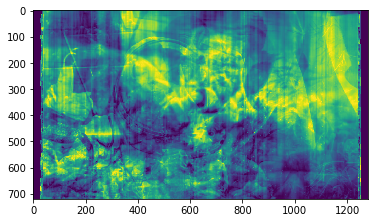

True
True
Crop range: 28 692


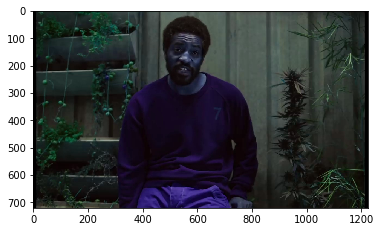

Crop range: 28 692


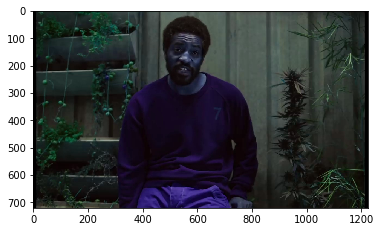

In [38]:
crop_dict = {}
failed = []
for movie in os.listdir(ROOT)[:5]:
    print('Running:', movie)
    
    # init
    li = []
    scaler = MinMax(feature_range=(0, 255), copy=True)
    
    # collect all middle frame in each scene
    for scene in os.listdir(ROOT + movie)[:10]:
        framePath = ROOT + movie + '/' + scene + '/frames/'
#         print(framePath, os.listdir(framePath))
        frameList = [int(name.split('.')[0]) for name in os.listdir(framePath)]
        frameList.sort()
#         print(frameList)
        keyframe = framePath + '/' + str(frameList[len(frameList)//2]) + '.jpg'
#         print(keyframe)
        
        # 讀取圖檔
        img = cv2.imread(keyframe)

        # 轉換至 HSV 色彩空間
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # 取出明度
        value = hsv[:,:,2]
        li.append(value)
    
    arr = np.asarray(li)
#     print(len(li), arr.shape)
    # sum up
    arr_sum = np.sum(arr, axis=0)
    print(arr_sum.shape, 'Max:',np.max(arr_sum), 'Min:',np.min(arr_sum))
    
    # Mapping between 0 and 255
    scaler.fit(arr_sum)
    arr_norm = scaler.transform(arr_sum)
#     print(np.max(arr_norm), np.min(arr_norm))
    
    h = arr_norm.shape[0]
    w = arr_norm.shape[1]
    
    _, threshold = cv2.threshold(arr_norm, 10, 255, cv2.THRESH_BINARY)
#     print(np.unique(threshold)) # only 0 and 255
    
    nonz = nonzero(arr_norm)
    nonz_thresh = nonzero(threshold)
    
    mode = count_mode(nonz)
    mode_thresh = count_mode(nonz_thresh)
    
    print('Crop range:',mode, h - mode)
    crop_img = img[mode: h - mode, :] # horizontal
#     crop_img = img[:, mode: w - mode] # vertical
    
    print('Crop range:',mode_thresh, h - mode_thresh)
    crop_img_thresh = img[mode_thresh: h - mode_thresh, :] # horizontal
#     crop_img = img[:, mode_thresh: w - mode_thresh] # vertical

    plt.subplot(131).set_title("Cropped"), plt.imshow(crop_img)
    plt.subplot(132).set_title("Cropped_thresh"), plt.imshow(crop_img_thresh)
    plt.subplot(133).set_title("Original"), plt.imshow(arr_norm)
    plt.show()
    
    # save crop dict
    usr_input = input()
    if usr_input == '1': 
        crop_dict[movie] = mode
    elif usr_input == '2':
        crop_dict[movie] = mode_thresh
    else:
        crop_dict[movie] = 0
        failed.append(movie)
    print('==================================================')

### Some dict problem

In [ ]:
failed

In [32]:
# # fail movies
# failed = ['childsplaymovie', 'httydragon', 'apollo11movie', 'hotelmumbaifilm']
# # vertical border
# stripe = ['highlifemovie']

In [41]:
len(crop_dict)

1

In [42]:
crop_dict

{'highlifemovie': 28}

In [40]:
type(crop_dict)

dict

In [16]:
# write_json(str(crop_dict), './json/crop_dict4Trailers.json')

In [30]:
# reload crop_dict test
dic = read_json('./json/crop_dict4Trailers.json')
print(type(dic))
dic = eval(dic)
print(type(dic))
print(dic['hotelmumbaifilm'])

<class 'str'>
<class 'dict'>
93


In [44]:
write_json(dic, './json/crop_dict4Trailers.json')

In [43]:
# especially for vertical
write_json({"highlifemovie": 28}, './json/crop_dict4Trailers_vertical.json')